In [4]:
# Import for preprocessing

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
pd.set_option('display.max_columns', None)

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection  import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.metrics import AUC

from sklearn import set_config
set_config(transform_output='pandas')

In [78]:
# Function to check metrics

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, ConfusionMatrixDisplay

def eval_classification(model, X_train, y_train, X_test, y_test, model_name = 'model', results_frame = None, pos_label=1, average='binary', roc_auc_avg = 'macro'):

  if isinstance(y_train, pd.Series):
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    if y_train.nunique() > 2 and average == 'binary':
      average = 'macro'

    print('Train Evaluation')
    print(classification_report(y_train, train_pred))
    ConfusionMatrixDisplay.from_predictions(y_train, train_pred, normalize='true', cmap='Blues')
    plt.show()

    print('Test Evaluation')
    print(classification_report(y_test, test_pred))
    ConfusionMatrixDisplay.from_predictions(y_test, test_pred, normalize='true', cmap='Greens')
    plt.show()

    results = pd.DataFrame(index=[model_name])
    results['train_acc'] = accuracy_score(y_train, train_pred)
    results['test_acc'] = accuracy_score(y_test, test_pred)
    results['train_prec'] = precision_score(y_train, train_pred, pos_label=pos_label, average=average)
    results['test_prec'] = precision_score(y_test, test_pred, pos_label=pos_label, average=average)
    results['train_recall'] = recall_score(y_train, train_pred, pos_label=pos_label, average=average)
    results['test_recall'] = recall_score(y_test, test_pred, pos_label=pos_label, average=average)
    results['train_f1'] = f1_score(y_train, train_pred, pos_label=pos_label, average=average)
    results['test_f1'] = f1_score(y_test, test_pred, pos_label=pos_label, average=average)
    results['train_auc'] = roc_auc_score(y_train, model.predict_proba(X_train)[:,1], average=roc_auc_avg, multi_class='ovr')
    results['test_auc'] = roc_auc_score(y_test, model.predict_proba(X_test)[:,1], average=roc_auc_avg, multi_class='ovr')

  else:

    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    y_train_labels = np.argmax(y_train, axis=1)
    y_test_labels = np.argmax(y_test, axis=1)
    train_pred_flat = np.argmax(train_pred, axis=1)
    test_pred_flat = np.argmax(test_pred, axis=1)

    print('Train Evaluation')
    print(classification_report(y_train_labels, train_pred_flat))
    ConfusionMatrixDisplay.from_predictions(y_train_labels, train_pred_flat, normalize='true', cmap='Blues')
    plt.show()

    print('Test Evaluation')
    print(classification_report(y_test_labels, test_pred_flat))
    ConfusionMatrixDisplay.from_predictions(y_test_labels, test_pred_flat, normalize='true', cmap='Greens')
    plt.show()

    results = pd.DataFrame(index=[model_name])
    results['train_acc'] = accuracy_score(y_train_labels, train_pred_flat)
    results['test_acc'] = accuracy_score(y_test_labels, test_pred_flat)
    results['train_prec'] = precision_score(y_train_labels, train_pred_flat, pos_label=pos_label, average=average)
    results['test_prec'] = precision_score(y_test_labels, test_pred_flat, pos_label=pos_label, average=average)
    results['train_recall'] = recall_score(y_train_labels, train_pred_flat, pos_label=pos_label, average=average)
    results['test_recall'] = recall_score(y_test_labels, test_pred_flat, pos_label=pos_label, average=average)
    results['train_f1'] = f1_score(y_train_labels, train_pred_flat, pos_label=pos_label, average=average)
    results['test_f1'] = f1_score(y_test_labels, test_pred_flat, pos_label=pos_label, average=average)
    results['train_auc'] = roc_auc_score(y_train, train_pred, average=roc_auc_avg, multi_class='ovr')
    results['test_auc'] = roc_auc_score(y_test, test_pred, average=roc_auc_avg, multi_class='ovr')

  if results_frame is not None:
    results = pd.concat([results_frame, results])

  return results


In [6]:
# import

df = pd.read_csv('merged_clean.csv')
df

,season_x,team_x,status,height,weight,player_id_x,years_exp,game_type_x,entry_year,age,cleaned_name_x,std_pos_x,unique_id,active_games,max_week,missed_games,birth_year,tgt_sh,ay_sh,yac_sh,ry_sh,rtd_sh,rfd_sh,rtdfd_sh,yptmpa,ppr_sh,completions_summed,attempts_summed,passing_yards_summed,passing_tds_summed,interceptions_summed,sacks_summed,sack_yards_summed,sack_fumbles_summed,sack_fumbles_lost_summed,passing_air_yards_summed,passing_first_downs_summed,passing_2pt_conversions_summed,carries_summed,rushing_yards_summed,rushing_tds_summed,rushing_fumbles_summed,rushing_fumbles_lost_summed,rushing_first_downs_summed,rushing_2pt_conversions_summed,receptions_summed,targets_summed,receiving_yards_summed,receiving_tds_summed,receiving_fumbles_summed,receiving_fumbles_lost_summed,receiving_air_yards_summed,receiving_yards_after_catch_summed,receiving_first_downs_summed,receiving_2pt_conversions_summed,special_teams_tds_summed,report_primary_injury,report_status,practice_primary_injury,practice_status,doubt,out,prob,quest,fp,dnp,lp,Hamstring,Knee,Ankle,Groin,Neck,Concussion,Foot,Back,Achilles
0,2009.0,PHI,ACT,70.0,200.0,00-0000108,12.0,WC,1997.0,35.0,David Akers,K,00-0000108_2009_David_Akers_K,18.0,18.0,0.0,1974.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Inj,Active,No Inj,Full Participation In Practice,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2010.0,PHI,ACT,70.0,200.0,00-0000108,13.0,WC,1997.0,36.0,David Akers,K,00-0000108_2010_David_Akers_K,18.0,18.0,0.0,1974.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Hamstring,Active,Hamstring,Full Participation in Practice,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2011.0,SF,ACT,70.0,200.0,00-0000108,14.0,CON,1997.0,37.0,David Akers,K,00-0000108_2011_David_Akers_K,20.0,20.0,0.0,1974.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.047313,1.0,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Inj,Active,No Inj,Full Participation In Practice,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2012.0,SF,ACT,70.0,200.0,00-0000108,15.0,SB,1997.0,38.0,David Akers,K,00-0000108_2012_David_Akers_K,21.0,21.0,0.0,1974.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Hip,Probable,Hip,Full Participation in Practice,0.0,0.0,5.0,0.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2013.0,DET,ACT,70.0,200.0,00-0000108,16.0,REG,1997.0,39.0,David Akers,K,00-0000108_2013_David_Akers_K,17.0,17.0,0.0,1974.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Inj,Active,No Inj,Full Participation In Practice,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13494,2024.0,SEA,CUT,67.0,195.0,00-0039940,0.0,REG,2024.0,24.0,Kairee Robinson,RB,00-0039940_2024_Kairee_Robinson_RB,0.0,18.0,18.0,2000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Inj,Active,No Inj,Full Participation In Practice,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13495,2024.0,KC,CUT,77.0,240.0,00-0039941,0.0,REG,2024.0,25.0,Geor'Quarius Spivey,TE,00-0039941_2024_Geor'Quarius_Spivey_TE,0.0,22.0,22.0,1999.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [7]:
df = df.sort_values(['player_id_x', 'season_x'], ascending=False)
df

,season_x,team_x,status,height,weight,player_id_x,years_exp,game_type_x,entry_year,age,cleaned_name_x,std_pos_x,unique_id,active_games,max_week,missed_games,birth_year,tgt_sh,ay_sh,yac_sh,ry_sh,rtd_sh,rfd_sh,rtdfd_sh,yptmpa,ppr_sh,completions_summed,attempts_summed,passing_yards_summed,passing_tds_summed,interceptions_summed,sacks_summed,sack_yards_summed,sack_fumbles_summed,sack_fumbles_lost_summed,passing_air_yards_summed,passing_first_downs_summed,passing_2pt_conversions_summed,carries_summed,rushing_yards_summed,rushing_tds_summed,rushing_fumbles_summed,rushing_fumbles_lost_summed,rushing_first_downs_summed,rushing_2pt_conversions_summed,receptions_summed,targets_summed,receiving_yards_summed,receiving_tds_summed,receiving_fumbles_summed,receiving_fumbles_lost_summed,receiving_air_yards_summed,receiving_yards_after_catch_summed,receiving_first_downs_summed,receiving_2pt_conversions_summed,special_teams_tds_summed,report_primary_injury,report_status,practice_primary_injury,practice_status,doubt,out,prob,quest,fp,dnp,lp,Hamstring,Knee,Ankle,Groin,Neck,Concussion,Foot,Back,Achilles
13498,2024.0,SEA,CUT,78.0,240.0,00-0039952,0.0,REG,2024.0,25.0,Devon Garrison,TE,00-0039952_2024_Devon_Garrison_TE,0.0,18.0,18.0,1999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Inj,Active,No Inj,Full Participation In Practice,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13497,2024.0,GB,DEV,72.0,205.0,00-0039945,0.0,WC,2024.0,26.0,Alex Hale,K,00-0039945_2024_Alex_Hale_K,0.0,19.0,19.0,1998.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Inj,Active,No Inj,Full Participation In Practice,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13496,2024.0,NO,CUT,76.0,260.0,00-0039942,0.0,REG,2024.0,23.0,Mason Fairchild,TE,00-0039942_2024_Mason_Fairchild_TE,0.0,18.0,18.0,2001.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Inj,Active,No Inj,Full Participation In Practice,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13495,2024.0,KC,CUT,77.0,240.0,00-0039941,0.0,REG,2024.0,25.0,Geor'Quarius Spivey,TE,00-0039941_2024_Geor'Quarius_Spivey_TE,0.0,22.0,22.0,1999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Inj,Active,No Inj,Full Participation In Practice,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13494,2024.0,SEA,CUT,67.0,195.0,00-0039940,0.0,REG,2024.0,24.0,Kairee Robinson,RB,00-0039940_2024_Kairee_Robinson_RB,0.0,18.0,18.0,2000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Inj,Active,No Inj,Full Participation In Practice,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2013.0,DET,ACT,70.0,200.0,00-0000108,16.0,REG,1997.0,39.0,David Akers,K,00-0000108_2013_David_Akers_K,17.0,17.0,0.0,1974.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Inj,Active,No Inj,Full Participation In Practice,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2012.0,SF,ACT,70.0,200.0,00-0000108,15.0,SB,1997.0,38.0,David Akers,K,00-0000108_2012_David_Akers_K,21.0,21.0,0.0,1974.0,0.0,

In [8]:
df['years_exp']

# make sure you are cycling over players

#filter and shift for only each play

# drop nans

df['next_season_missed'] = df.groupby('player_id_x')['missed_games'].shift(1)

In [9]:
df

,season_x,team_x,status,height,weight,player_id_x,years_exp,game_type_x,entry_year,age,cleaned_name_x,std_pos_x,unique_id,active_games,max_week,missed_games,birth_year,tgt_sh,ay_sh,yac_sh,ry_sh,rtd_sh,rfd_sh,rtdfd_sh,yptmpa,ppr_sh,completions_summed,attempts_summed,passing_yards_summed,passing_tds_summed,interceptions_summed,sacks_summed,sack_yards_summed,sack_fumbles_summed,sack_fumbles_lost_summed,passing_air_yards_summed,passing_first_downs_summed,passing_2pt_conversions_summed,carries_summed,rushing_yards_summed,rushing_tds_summed,rushing_fumbles_summed,rushing_fumbles_lost_summed,rushing_first_downs_summed,rushing_2pt_conversions_summed,receptions_summed,targets_summed,receiving_yards_summed,receiving_tds_summed,receiving_fumbles_summed,receiving_fumbles_lost_summed,receiving_air_yards_summed,receiving_yards_after_catch_summed,receiving_first_downs_summed,receiving_2pt_conversions_summed,special_teams_tds_summed,report_primary_injury,report_status,practice_primary_injury,practice_status,doubt,out,prob,quest,fp,dnp,lp,Hamstring,Knee,Ankle,Groin,Neck,Concussion,Foot,Back,Achilles,next_season_missed
13498,2024.0,SEA,CUT,78.0,240.0,00-0039952,0.0,REG,2024.0,25.0,Devon Garrison,TE,00-0039952_2024_Devon_Garrison_TE,0.0,18.0,18.0,1999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Inj,Active,No Inj,Full Participation In Practice,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
13497,2024.0,GB,DEV,72.0,205.0,00-0039945,0.0,WC,2024.0,26.0,Alex Hale,K,00-0039945_2024_Alex_Hale_K,0.0,19.0,19.0,1998.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Inj,Active,No Inj,Full Participation In Practice,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
13496,2024.0,NO,CUT,76.0,260.0,00-0039942,0.0,REG,2024.0,23.0,Mason Fairchild,TE,00-0039942_2024_Mason_Fairchild_TE,0.0,18.0,18.0,2001.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Inj,Active,No Inj,Full Participation In Practice,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
13495,2024.0,KC,CUT,77.0,240.0,00-0039941,0.0,REG,2024.0,25.0,Geor'Quarius Spivey,TE,00-0039941_2024_Geor'Quarius_Spivey_TE,0.0,22.0,22.0,1999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Inj,Active,No Inj,Full Participation In Practice,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
13494,2024.0,SEA,CUT,67.0,195.0,00-0039940,0.0,REG,2024.0,24.0,Kairee Robinson,RB,00-0039940_2024_Kairee_Robinson_RB,0.0,18.0,18.0,2000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Inj,Active,No Inj,Full Participation In Practice,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2013.0,DET,ACT,70.0,200.0,00-0000108,16.0,REG,1997.0,39.0,David Akers,K,00-0000108_2013_David_Akers_K,17.0,17.0,0.0,1974.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Inj,Active,No Inj,Full Participation In Practice,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,2012.0,SF,ACT,70.0,200.0,00-0000108,15.0,SB,1997.0,38.0,David Akers,K,00-00001

In [10]:
df['missed4'] = np.where(df['next_season_missed'] >= 4, 1, 0)

In [11]:
df['next_season_missed'].isna().sum()

3438

In [12]:
df['player_id_x'].nunique()

3438

In [13]:
# df = df.dropna(subset='next_season_missed')

In [14]:
df[(df['years_exp'] > 0) & (df['season_x'] == 2024)]

,season_x,team_x,status,height,weight,player_id_x,years_exp,game_type_x,entry_year,age,cleaned_name_x,std_pos_x,unique_id,active_games,max_week,missed_games,birth_year,tgt_sh,ay_sh,yac_sh,ry_sh,rtd_sh,rfd_sh,rtdfd_sh,yptmpa,ppr_sh,completions_summed,attempts_summed,passing_yards_summed,passing_tds_summed,interceptions_summed,sacks_summed,sack_yards_summed,sack_fumbles_summed,sack_fumbles_lost_summed,passing_air_yards_summed,passing_first_downs_summed,passing_2pt_conversions_summed,carries_summed,rushing_yards_summed,rushing_tds_summed,rushing_fumbles_summed,rushing_fumbles_lost_summed,rushing_first_downs_summed,rushing_2pt_conversions_summed,receptions_summed,targets_summed,receiving_yards_summed,receiving_tds_summed,receiving_fumbles_summed,receiving_fumbles_lost_summed,receiving_air_yards_summed,receiving_yards_after_catch_summed,receiving_first_downs_summed,receiving_2pt_conversions_summed,special_teams_tds_summed,report_primary_injury,report_status,practice_primary_injury,practice_status,doubt,out,prob,quest,fp,dnp,lp,Hamstring,Knee,Ankle,Groin,Neck,Concussion,Foot,Back,Achilles,next_season_missed,missed4
13272,2024.0,DET,ACT,70.0,202.0,00-0039172,1.0,DIV,2023.0,25.0,Jake Bates,K,00-0039172_2024_Jake_Bates_K,18.0,20.0,2.0,1999.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Inj,Active,No Inj,Full Participation In Practice,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0
13271,2024.0,SEA,ACT,73.0,220.0,00-0039165,1.0,REG,2023.0,23.0,Zach Charbonnet,RB,00-0039165_2024_Zach_Charbonnet_RB,17.0,18.0,1.0,2001.0,0.087690,-0.013126,0.157678,0.070336,0.047619,0.033175,0.034483,0.519393,0.125345,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,135.0,569.0,8.0,0.0,0.0,32.0,0.0,42.0,52.0,308.0,1.0,0.0,0.0,-54.0,345.0,7.0,0.0,0.0,Elbow,Active,Elbow,Full Participation in Practice,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0
13269,2024.0,IND,INA,76.0,232.0,00-0039164,1.0,REG,2023.0,22.0,Anthony Richardson,QB,00-0039164_2024_Anthony_Richardson_QB,13.0,18.0,5.0,2002.0,0.003448,-0.002288,0.008235,-0.000505,0.000000,0.000000,0.000000,-0.003448,0.218343,126.0,264.0,1814.0,8.0,12.0,14.0,115.0,3.0,2.0,3224.0,73.0,0.0,86.0,499.0,6.0,6.0,1.0,33.0,1.0,1.0,1.0,-1.0,0.0,0.0,0.0,-8.0,7.0,0.0,0.0,0.0,Back,Out,Back,Did Not Participate In Practice,0.0,0.0,0.0,3.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,NaN,0
13267,2024.0,HOU,ACT,75.0,218.0,00-0039163,1.0,DIV,2023.0,23.0,C.J. Stroud,QB,00-0039163_2024_C.J._Stroud_QB,19.0,20.0,1.0,2001.0,0.001585,0.001908,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.165953,377.0,593.0,4254.0,21.0,13.0,63.0,487.0,5.0,2.0,5011.0,211.0,0.0,64.0,317.0,0.0,3.0,2.0,19.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,Hand,Active,Hand,Full Participation in Practice,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0
13265,2024.0,TEN,ACT,76.0,232.0,00-0039152,1.0,REG,2023.0,25.0,Will Levis,QB,00-0039152_2024_Will_Levis_QB,14.0,18.0,4.0,1999.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.140709,190.0,301.0,2091.0,13.0,12.0,41.0,233.0,5.0,3.0,2621.0,86.0,1.0,45.0,183.0,0.0,5.0,3.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Shoulder,Questionable,Shoulder,Limited Participation in Practice,0.0,0.0,0.0,4.0,3.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994,2024.0,ATL,RET,76.0,217.0,00-0026143,16.0,REG,2008.0,39.0,Matt Ryan,QB,00-0026143_2024_Matt_Ryan_QB,0.0,18.0,18.0,1985.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

In [15]:
train_df = df[df['season_x'] < 2023]
test_df = df[df['season_x'] == 2023]

In [16]:
test_df

,season_x,team_x,status,height,weight,player_id_x,years_exp,game_type_x,entry_year,age,cleaned_name_x,std_pos_x,unique_id,active_games,max_week,missed_games,birth_year,tgt_sh,ay_sh,yac_sh,ry_sh,rtd_sh,rfd_sh,rtdfd_sh,yptmpa,ppr_sh,completions_summed,attempts_summed,passing_yards_summed,passing_tds_summed,interceptions_summed,sacks_summed,sack_yards_summed,sack_fumbles_summed,sack_fumbles_lost_summed,passing_air_yards_summed,passing_first_downs_summed,passing_2pt_conversions_summed,carries_summed,rushing_yards_summed,rushing_tds_summed,rushing_fumbles_summed,rushing_fumbles_lost_summed,rushing_first_downs_summed,rushing_2pt_conversions_summed,receptions_summed,targets_summed,receiving_yards_summed,receiving_tds_summed,receiving_fumbles_summed,receiving_fumbles_lost_summed,receiving_air_yards_summed,receiving_yards_after_catch_summed,receiving_first_downs_summed,receiving_2pt_conversions_summed,special_teams_tds_summed,report_primary_injury,report_status,practice_primary_injury,practice_status,doubt,out,prob,quest,fp,dnp,lp,Hamstring,Knee,Ankle,Groin,Neck,Concussion,Foot,Back,Achilles,next_season_missed,missed4
13270,2023.0,SEA,ACT,73.0,220.0,00-0039165,0.0,REG,2023.0,22.0,Zach Charbonnet,RB,00-0039165_2023_Zach_Charbonnet_RB,16.0,18.0,2.0,2001.0,0.072595,-0.010534,0.125506,0.052938,0.000,0.039326,0.035176,0.379310,0.080979,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,108.0,462.0,1.0,0.0,0.0,32.0,0.0,33.0,40.0,209.0,0.0,0.0,0.0,-41.0,248.0,7.0,0.0,0.0,Knee,Questionable,Knee,Full Participation in Practice,0.0,0.0,0.0,2.0,2.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
13268,2023.0,IND,RES,76.0,232.0,00-0039164,0.0,REG,2023.0,21.0,Anthony Richardson,QB,00-0039164_2023_Anthony_Richardson_QB,4.0,18.0,14.0,2002.0,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.213689,50.0,84.0,577.0,3.0,1.0,7.0,29.0,1.0,0.0,676.0,31.0,2.0,25.0,136.0,4.0,2.0,1.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Concussion,Active,Concussion,Full Participation in Practice,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,5.0,1
13266,2023.0,HOU,ACT,75.0,218.0,00-0039163,0.0,DIV,2023.0,22.0,C.J. Stroud,QB,00-0039163_2023_C.J._Stroud_QB,17.0,20.0,3.0,2001.0,0.001779,-0.000201,0.000491,0.000000,0.000,0.000000,0.000000,0.000000,0.206308,354.0,553.0,4557.0,26.0,5.0,38.0,331.0,6.0,3.0,4908.0,206.0,0.0,43.0,167.0,3.0,2.0,1.0,17.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,Concussion,Active,Concussion,Full Participation in Practice,1.0,0.0,0.0,1.0,3.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0
13264,2023.0,TEN,INA,76.0,232.0,00-0039152,0.0,REG,2023.0,24.0,Will Levis,QB,00-0039152_2023_Will_Levis_QB,9.0,18.0,9.0,1999.0,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.159821,149.0,255.0,1808.0,8.0,4.0,28.0,185.0,5.0,2.0,2688.0,81.0,1.0,25.0,57.0,1.0,2.0,2.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Foot,Questionable,Foot,Limited Participation in Practice,0.0,0.0,0.0,2.0,8.0,0.0,2.0,0.0,0.0,6.0,0.0,0.0,0.0,3.0,0.0,0.0,4.0,1
13262,2023.0,CAR,ACT,70.0,194.0,00-0039150,0.0,REG,2023.0,22.0,Bryce Young,QB,00-0039150_2023_Bryce_Young_QB,16.0,18.0,2.0,2001.0,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.154486,315.0,527.0,2877.0,11.0,10.0,62.0,477.0,9.0,6.0,4009.0,133.0,1.0,39.0,253.0,0.0,2.0,0.0,18.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Back,Active,Back,Full Participation in Practice,0.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1785,2023.0,NYG,ACT,73.0,207.0,00-0025580,16.0,REG,2007.0,39.0,Mason Crosby,K,00-0025580_2023_Mason_Crosby_K,3.0,18.0,15.0,1984.0,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.00

In [17]:
test_df['next_season_missed'].isna().sum()

173

In [18]:
test_df = test_df.dropna(subset='next_season_missed')

In [19]:
test_df['season_x'].value_counts()

season_x
2023.0    793
Name: count, dtype: int64

In [20]:
test_df

,season_x,team_x,status,height,weight,player_id_x,years_exp,game_type_x,entry_year,age,cleaned_name_x,std_pos_x,unique_id,active_games,max_week,missed_games,birth_year,tgt_sh,ay_sh,yac_sh,ry_sh,rtd_sh,rfd_sh,rtdfd_sh,yptmpa,ppr_sh,completions_summed,attempts_summed,passing_yards_summed,passing_tds_summed,interceptions_summed,sacks_summed,sack_yards_summed,sack_fumbles_summed,sack_fumbles_lost_summed,passing_air_yards_summed,passing_first_downs_summed,passing_2pt_conversions_summed,carries_summed,rushing_yards_summed,rushing_tds_summed,rushing_fumbles_summed,rushing_fumbles_lost_summed,rushing_first_downs_summed,rushing_2pt_conversions_summed,receptions_summed,targets_summed,receiving_yards_summed,receiving_tds_summed,receiving_fumbles_summed,receiving_fumbles_lost_summed,receiving_air_yards_summed,receiving_yards_after_catch_summed,receiving_first_downs_summed,receiving_2pt_conversions_summed,special_teams_tds_summed,report_primary_injury,report_status,practice_primary_injury,practice_status,doubt,out,prob,quest,fp,dnp,lp,Hamstring,Knee,Ankle,Groin,Neck,Concussion,Foot,Back,Achilles,next_season_missed,missed4
13270,2023.0,SEA,ACT,73.0,220.0,00-0039165,0.0,REG,2023.0,22.0,Zach Charbonnet,RB,00-0039165_2023_Zach_Charbonnet_RB,16.0,18.0,2.0,2001.0,0.072595,-0.010534,0.125506,0.052938,0.000,0.039326,0.035176,0.379310,0.080979,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,108.0,462.0,1.0,0.0,0.0,32.0,0.0,33.0,40.0,209.0,0.0,0.0,0.0,-41.0,248.0,7.0,0.0,0.0,Knee,Questionable,Knee,Full Participation in Practice,0.0,0.0,0.0,2.0,2.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
13268,2023.0,IND,RES,76.0,232.0,00-0039164,0.0,REG,2023.0,21.0,Anthony Richardson,QB,00-0039164_2023_Anthony_Richardson_QB,4.0,18.0,14.0,2002.0,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.213689,50.0,84.0,577.0,3.0,1.0,7.0,29.0,1.0,0.0,676.0,31.0,2.0,25.0,136.0,4.0,2.0,1.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Concussion,Active,Concussion,Full Participation in Practice,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,5.0,1
13266,2023.0,HOU,ACT,75.0,218.0,00-0039163,0.0,DIV,2023.0,22.0,C.J. Stroud,QB,00-0039163_2023_C.J._Stroud_QB,17.0,20.0,3.0,2001.0,0.001779,-0.000201,0.000491,0.000000,0.000,0.000000,0.000000,0.000000,0.206308,354.0,553.0,4557.0,26.0,5.0,38.0,331.0,6.0,3.0,4908.0,206.0,0.0,43.0,167.0,3.0,2.0,1.0,17.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,Concussion,Active,Concussion,Full Participation in Practice,1.0,0.0,0.0,1.0,3.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0
13264,2023.0,TEN,INA,76.0,232.0,00-0039152,0.0,REG,2023.0,24.0,Will Levis,QB,00-0039152_2023_Will_Levis_QB,9.0,18.0,9.0,1999.0,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.159821,149.0,255.0,1808.0,8.0,4.0,28.0,185.0,5.0,2.0,2688.0,81.0,1.0,25.0,57.0,1.0,2.0,2.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Foot,Questionable,Foot,Limited Participation in Practice,0.0,0.0,0.0,2.0,8.0,0.0,2.0,0.0,0.0,6.0,0.0,0.0,0.0,3.0,0.0,0.0,4.0,1
13262,2023.0,CAR,ACT,70.0,194.0,00-0039150,0.0,REG,2023.0,22.0,Bryce Young,QB,00-0039150_2023_Bryce_Young_QB,16.0,18.0,2.0,2001.0,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.154486,315.0,527.0,2877.0,11.0,10.0,62.0,477.0,9.0,6.0,4009.0,133.0,1.0,39.0,253.0,0.0,2.0,0.0,18.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Back,Active,Back,Full Participation in Practice,0.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2028,2023.0,CLE,ACT,78.0,245.0,00-0026158,15.0,WC,2008.0,38.0,Joe Flacco,QB,00-0026158_2023_Joe_Flacco_QB,7.0,19.0,12.0,1985.0,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.00000

In [21]:
train_df['next_season_missed'].isna().sum()

2229

In [22]:
train_df = train_df.dropna(subset='next_season_missed')

In [23]:
train_df

,season_x,team_x,status,height,weight,player_id_x,years_exp,game_type_x,entry_year,age,cleaned_name_x,std_pos_x,unique_id,active_games,max_week,missed_games,birth_year,tgt_sh,ay_sh,yac_sh,ry_sh,rtd_sh,rfd_sh,rtdfd_sh,yptmpa,ppr_sh,completions_summed,attempts_summed,passing_yards_summed,passing_tds_summed,interceptions_summed,sacks_summed,sack_yards_summed,sack_fumbles_summed,sack_fumbles_lost_summed,passing_air_yards_summed,passing_first_downs_summed,passing_2pt_conversions_summed,carries_summed,rushing_yards_summed,rushing_tds_summed,rushing_fumbles_summed,rushing_fumbles_lost_summed,rushing_first_downs_summed,rushing_2pt_conversions_summed,receptions_summed,targets_summed,receiving_yards_summed,receiving_tds_summed,receiving_fumbles_summed,receiving_fumbles_lost_summed,receiving_air_yards_summed,receiving_yards_after_catch_summed,receiving_first_downs_summed,receiving_2pt_conversions_summed,special_teams_tds_summed,report_primary_injury,report_status,practice_primary_injury,practice_status,doubt,out,prob,quest,fp,dnp,lp,Hamstring,Knee,Ankle,Groin,Neck,Concussion,Foot,Back,Achilles,next_season_missed,missed4
12910,2022.0,ATL,ACT,72.0,193.0,00-0038149,0.0,REG,2022.0,23.0,Josh Ali,WR,00-0038149_2022_Josh_Ali_WR,2.0,18.0,16.0,1999.0,0.033333,0.127119,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,45.0,0.0,0.0,0.0,0.0,No Inj,Active,No Inj,Full Participation In Practice,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,1
12907,2022.0,CLE,DEV,74.0,219.0,00-0038147,0.0,REG,2022.0,23.0,Daylen Baldwin,WR,00-0038147_2022_Daylen_Baldwin_WR,1.0,18.0,17.0,1999.0,0.071429,0.193798,0.00000,0.155280,0.0,0.200000,0.181818,0.892857,0.069402,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,25.0,0.0,0.0,0.0,25.0,0.0,2.0,0.0,0.0,No Inj,Active,No Inj,Full Participation In Practice,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,1
12904,2022.0,TEN,DEV,78.0,260.0,00-0038145,0.0,REG,2022.0,25.0,Thomas Odukoya,TE,00-0038145_2022_Thomas_Odukoya_TE,0.0,18.0,18.0,1997.0,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Inj,Active,No Inj,Full Participation In Practice,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,1
12900,2022.0,SEA,ACT,69.0,210.0,00-0038134,0.0,WC,2022.0,22.0,Kenneth Walker,RB,00-0038134_2022_Kenneth_Walker_RB,16.0,19.0,3.0,2000.0,0.066176,-0.018262,0.13046,0.041217,0.0,0.030303,0.026667,0.308824,0.147303,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,243.0,1113.0,10.0,0.0,0.0,55.0,0.0,28.0,36.0,168.0,0.0,0.0,0.0,-75.0,224.0,6.0,0.0,0.0,Ankle,Active,Ankle,Limited Participation in Practice,0.0,0.0,0.0,5.0,6.0,3.0,3.0,0.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0
12897,2022.0,CAR,RES,74.0,205.0,00-0038132,0.0,REG,2022.0,23.0,Matt Corral,QB,00-0038132_2022_Matt_Corral_QB,0.0,18.0,18.0,1999.0,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Inj,Active,No Inj,Full Participation In Practice,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,2009.0,PIT,ACT,74.0,216.0,00-0000865,11.0,REG,1998.0,35.0,Charlie Batch,QB,00-0000865_2009_Charlie_Batch_QB,17.0,17.0,0.0,1974.0,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.005375,1.0,2.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [24]:
col_list = train_df.columns.to_list()

In [25]:
col_list

['season_x',
 'team_x',
 'status',
 'height',
 'weight',
 'player_id_x',
 'years_exp',
 'game_type_x',
 'entry_year',
 'age',
 'cleaned_name_x',
 'std_pos_x',
 'unique_id',
 'active_games',
 'max_week',
 'missed_games',
 'birth_year',
 'tgt_sh',
 'ay_sh',
 'yac_sh',
 'ry_sh',
 'rtd_sh',
 'rfd_sh',
 'rtdfd_sh',
 'yptmpa',
 'ppr_sh',
 'completions_summed',
 'attempts_summed',
 'passing_yards_summed',
 'passing_tds_summed',
 'interceptions_summed',
 'sacks_summed',
 'sack_yards_summed',
 'sack_fumbles_summed',
 'sack_fumbles_lost_summed',
 'passing_air_yards_summed',
 'passing_first_downs_summed',
 'passing_2pt_conversions_summed',
 'carries_summed',
 'rushing_yards_summed',
 'rushing_tds_summed',
 'rushing_fumbles_summed',
 'rushing_fumbles_lost_summed',
 'rushing_first_downs_summed',
 'rushing_2pt_conversions_summed',
 'receptions_summed',
 'targets_summed',
 'receiving_yards_summed',
 'receiving_tds_summed',
 'receiving_fumbles_summed',
 'receiving_fumbles_lost_summed',
 'receiving_air

In [26]:
X_train = train_df.drop(columns=['status', 'player_id_x', 'cleaned_name_x', 'unique_id', 'active_games', 'report_primary_injury',
                                 'report_status', 'practice_primary_injury', 'practice_status', 'next_season_missed', 'missed4'])

y_train = train_df['missed4'].copy()

X_test = test_df.drop(columns=['status', 'player_id_x', 'cleaned_name_x', 'unique_id', 'active_games', 'report_primary_injury',
                                 'report_status', 'practice_primary_injury', 'practice_status', 'next_season_missed', 'missed4'])

y_test = test_df['missed4'].copy()

In [27]:
X_train.columns

Index(['season_x', 'team_x', 'height', 'weight', 'years_exp', 'game_type_x',
       'entry_year', 'age', 'std_pos_x', 'max_week', 'missed_games',
       'birth_year', 'tgt_sh', 'ay_sh', 'yac_sh', 'ry_sh', 'rtd_sh', 'rfd_sh',
       'rtdfd_sh', 'yptmpa', 'ppr_sh', 'completions_summed', 'attempts_summed',
       'passing_yards_summed', 'passing_tds_summed', 'interceptions_summed',
       'sacks_summed', 'sack_yards_summed', 'sack_fumbles_summed',
       'sack_fumbles_lost_summed', 'passing_air_yards_summed',
       'passing_first_downs_summed', 'passing_2pt_conversions_summed',
       'carries_summed', 'rushing_yards_summed', 'rushing_tds_summed',
       'rushing_fumbles_summed', 'rushing_fumbles_lost_summed',
       'rushing_first_downs_summed', 'rushing_2pt_conversions_summed',
       'receptions_summed', 'targets_summed', 'receiving_yards_summed',
       'receiving_tds_summed', 'receiving_fumbles_summed',
       'receiving_fumbles_lost_summed', 'receiving_air_yards_summed',
       're

In [28]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9268 entries, 12910 to 0
Data columns (total 67 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   season_x                            9268 non-null   float64
 1   team_x                              9268 non-null   object 
 2   height                              9268 non-null   float64
 3   weight                              9268 non-null   float64
 4   years_exp                           9268 non-null   float64
 5   game_type_x                         9268 non-null   object 
 6   entry_year                          9268 non-null   float64
 7   age                                 9268 non-null   float64
 8   std_pos_x                           9268 non-null   object 
 9   max_week                            9268 non-null   float64
 10  missed_games                        9268 non-null   float64
 11  birth_year                          9268 non-nu

In [29]:
# Make transformers for preprocess

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
scaler = MinMaxScaler()

In [30]:
ohe_cols = list(X_train.select_dtypes('object').columns)
nums_cols = list(X_train.select_dtypes('float64').columns)

In [31]:
# Make the encoder for pipeline

proc_encode = ColumnTransformer([
  ('ohe', ohe, ohe_cols)
], remainder = 'passthrough', verbose_feature_names_out=False)

In [32]:
# Scaler transformer for pipeline

proc_scale = ColumnTransformer([
  ('scaler', scaler, nums_cols)
], remainder='passthrough', verbose_feature_names_out=False)

In [33]:
main_pipe = Pipeline([
  ('proc_encode', proc_encode),
  ('proc_scale', proc_scale)
])

In [34]:
main_pipe.fit(X_train)

c:\Users\nick_\anaconda3\envs\tensor\lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('proc_encode',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['team_x', 'game_type_x',
                                                   'std_pos_x'])],
                                   verbose_feature_names_out=False)),
                ('proc_scale',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', MinMaxScaler(),
                                                  ['season_x', 'height',
                                                   'weight'...
                                                   'rtdfd_sh', 'yptmpa',
                                                   'ppr_sh',
                                                   'completions_summed',
                                                   'attempts_summed',
                                                   'passing_yards_summed',
                                                   'passing_tds_summed',
                                                   'interceptions_summed',
                                                   'sacks_summed',
                                                   'sack_yards_summed',
                                                   'sack_fumbles_summed',
                                                   'sack_fumbles_lost_summed',
                                                   'passing_air_yards_summed',
                                                   'passing_first_downs_summed',
                                                   'passing_2pt_conversions_summed', ...])],
                                   verbose_feature_names_out=False))])

In [35]:
X_train_proc = main_pipe.transform(X_train)
X_test_proc = main_pipe.transform(X_test)

In [36]:
X_train_proc.head()

,season_x,height,weight,years_exp,entry_year,age,max_week,missed_games,birth_year,tgt_sh,ay_sh,yac_sh,ry_sh,rtd_sh,rfd_sh,rtdfd_sh,yptmpa,ppr_sh,completions_summed,attempts_summed,passing_yards_summed,passing_tds_summed,interceptions_summed,sacks_summed,sack_yards_summed,sack_fumbles_summed,sack_fumbles_lost_summed,passing_air_yards_summed,passing_first_downs_summed,passing_2pt_conversions_summed,carries_summed,rushing_yards_summed,rushing_tds_summed,rushing_fumbles_summed,rushing_fumbles_lost_summed,rushing_first_downs_summed,rushing_2pt_conversions_summed,receptions_summed,targets_summed,receiving_yards_summed,receiving_tds_summed,receiving_fumbles_summed,receiving_fumbles_lost_summed,receiving_air_yards_summed,receiving_yards_after_catch_summed,receiving_first_downs_summed,receiving_2pt_conversions_summed,special_teams_tds_summed,doubt,out,prob,quest,fp,dnp,lp,Hamstring,Knee,Ankle,Groin,Neck,Concussion,Foot,Back,Achilles,team_x_ARI,team_x_ARZ,team_x_ATL,team_x_BAL,team_x_BLT,team_x_BUF,team_x_CAR,team_x_CHI,team_x_CIN,team_x_CLE,team_x_CLV,team_x_DAL,team_x_DEN,team_x_DET,team_x_GB,team_x_HOU,team_x_HST,team_x_IND,team_x_JAX,team_x_KC,team_x_LA,team_x_LAC,team_x_LV,team_x_MIA,team_x_MIN,team_x_NE,team_x_NO,team_x_NYG,team_x_NYJ,team_x_OAK,team_x_PHI,team_x_PIT,team_x_SD,team_x_SEA,team_x_SF,team_x_SL,team_x_TB,team_x_TEN,team_x_WAS,game_type_x_CON,game_type_x_DIV,game_type_x_REG,game_type_x_SB,game_type_x_WC,std_pos_x_K,std_pos_x_QB,std_pos_x_RB,std_pos_x_TE,std_pos_x_WR
12910,1.0,0.4375,0.267081,0.0,1.0,0.076923,0.2,0.727273,0.945946,0.083333,0.350538,0.072107,0.057877,0.0,0.000000,0.000000,0.040199,0.478312,0.0,0.0,0.000928,0.0,0.0,0.0,0.0,0.0,0.0,0.001681,0.0,0.0,0.000000,0.014805,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.004292,0.006555,0.0,0.0,0.0,0.058069,0.007547,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12907,1.0,0.5625,0.428571,0.0,1.0,0.076923,0.2,0.772727,0.945946,0.178571,0.457429,0.072107,0.377819,0.0,0.434667,0.389006,0.205302,0.583631,0.0,0.0,0.000928,0.0,0.0,0.0,0.0,0.0,0.0,0.001681,0.0,0.0,0.000000,0.014805,0.00000,0.0,0.0,0.000000,0.0,0.011236,0.008584,0.016796,0.0,0.0,0.0,0.051317,0.007547,0.018519,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12904,1.0,0.8125,0.683230,0.0,1.0,0.153846,0.2,0.818182,0.891892,0.000000,0.146759,0.072107,0.057877,0.0,0.000000,0.000000,0.040199,0.478312,0.0,0.0,0.000928,0.0,0.0,0.0,0.0,0.0,0.0,0.001681,0.0,0.0,0.000000,0.014805,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.006555,0.0,0.0,0.0,0.042876,0.007547,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
12900,1.0,0.2500,0.372671,0.0,1.0,0.038462,0.4,0.136364,0.972973,0.165441,0.117485,0.316693,0.142801,0.0,0.065859,0.057054,0.097305,0.701848,0.0,0.0,0.000928,0.0,0.0,0.0,0.0,0.0,0.0,0.001681,0.0,0.0,0.557339,0.514132,0.47619,0.0,0.0,0.514019,0.0,0.157303,0.154506,0.075379,0.0,0.0,0.0,0.017556,0.218868,0.055556,0.0,0.0,0.0,0.0,0.0,0.333333,0.315789,0.176471,0.157895,0.0,0.066667,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
12897,1.0,0.5625,0.341615,0.0,1.0,0.076923,0.2,0.818182,0.945946,0.000000,0.14675

In [37]:
logreg_balc = LogisticRegression(max_iter=1000)

Train Evaluation
              precision    recall  f1-score   support

           0       0.72      0.76      0.74      4679
           1       0.74      0.69      0.72      4589

    accuracy                           0.73      9268
   macro avg       0.73      0.73      0.73      9268
weighted avg       0.73      0.73      0.73      9268



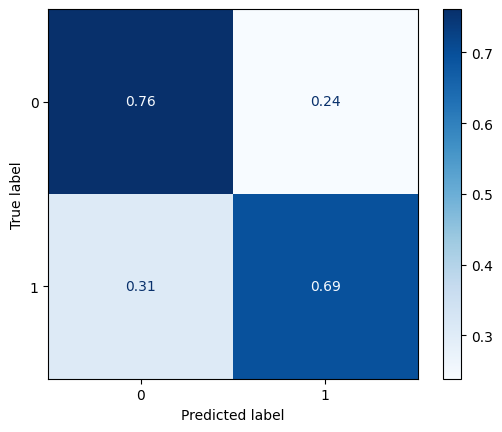

Test Evaluation
              precision    recall  f1-score   support

           0       0.63      0.33      0.43       269
           1       0.72      0.90      0.80       524

    accuracy                           0.71       793
   macro avg       0.68      0.61      0.62       793
weighted avg       0.69      0.71      0.68       793



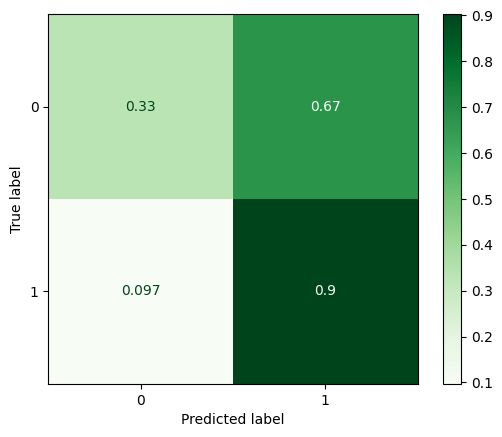

In [38]:
log_reg = eval_classification(logreg_balc, X_train_proc, y_train, X_test_proc, y_test, model_name='log_reg_notune')

In [39]:
log_reg

,train_acc,test_acc,train_prec,test_prec,train_recall,test_recall,train_f1,test_f1,train_auc,test_auc
log_reg_notune,0.728312,0.70744,0.740534,0.723242,0.694705,0.902672,0.716888,0.803056,0.796616,0.793886


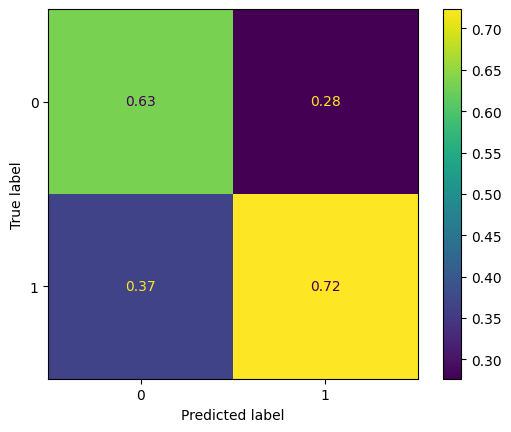

In [40]:
ConfusionMatrixDisplay.from_estimator(logreg_balc, X_test_proc, y_test, normalize='pred')

In [41]:
# tune decision threshold to make more stringent

In [42]:
dt = DecisionTreeClassifier()

Train Evaluation
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4679
           1       1.00      1.00      1.00      4589

    accuracy                           1.00      9268
   macro avg       1.00      1.00      1.00      9268
weighted avg       1.00      1.00      1.00      9268



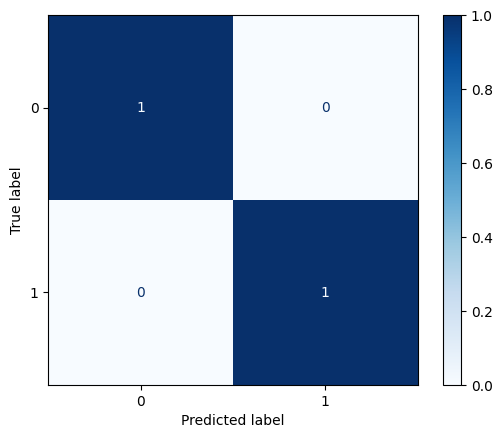

Test Evaluation
              precision    recall  f1-score   support

           0       0.46      0.51      0.49       269
           1       0.74      0.70      0.72       524

    accuracy                           0.63       793
   macro avg       0.60      0.60      0.60       793
weighted avg       0.64      0.63      0.64       793



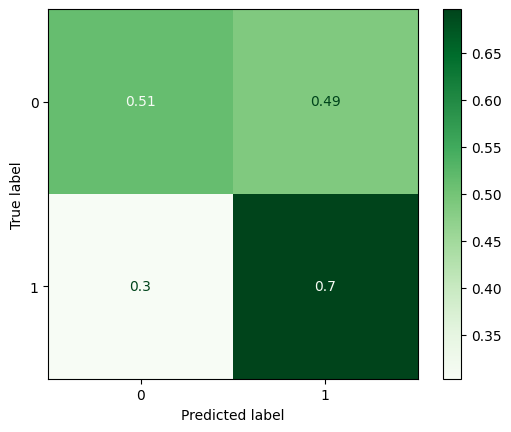

In [43]:
tree = eval_classification(dt, X_train_proc, y_train, X_test_proc, y_test, model_name= 'dt_no_tune', results_frame=log_reg)

In [44]:
dt

DecisionTreeClassifier()

In [45]:
rf = RandomForestClassifier()

Train Evaluation
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4679
           1       1.00      1.00      1.00      4589

    accuracy                           1.00      9268
   macro avg       1.00      1.00      1.00      9268
weighted avg       1.00      1.00      1.00      9268



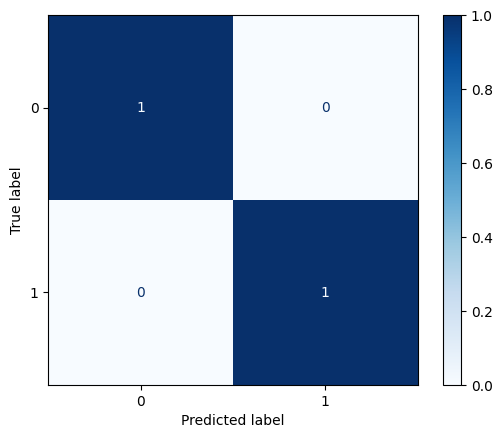

Test Evaluation
              precision    recall  f1-score   support

           0       0.62      0.61      0.62       269
           1       0.80      0.81      0.80       524

    accuracy                           0.74       793
   macro avg       0.71      0.71      0.71       793
weighted avg       0.74      0.74      0.74       793



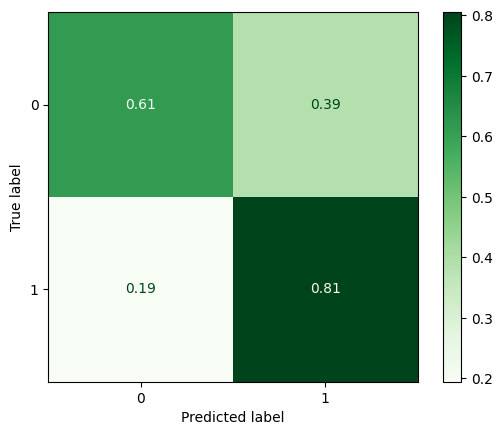

In [46]:
forest = eval_classification(rf, X_train_proc, y_train, X_test_proc, y_test, model_name="rf_no_tune", results_frame=tree)

In [47]:
forest

,train_acc,test_acc,train_prec,test_prec,train_recall,test_recall,train_f1,test_f1,train_auc,test_auc
log_reg_notune,0.728312,0.707440,0.740534,0.723242,0.694705,0.902672,0.716888,0.803056,0.796616,0.793886
dt_no_tune,1.000000,0.634300,1.000000,0.735887,1.000000,0.696565,1.000000,0.715686,1.000000,0.604788
rf_no_tune,1.000000,0.740227,1.000000,0.802281,1.000000,0.805344,1.000000,0.803810,1.000000,0.803506


In [48]:
# create estimators variable
estimators =  rf.estimators_

# check that it correctly shows for first tree
estimators[0]

DecisionTreeClassifier(max_features='sqrt', random_state=1291210674)

In [49]:
# Check for the maximum depth across all the trees

depths = [est.get_depth() for est in estimators]
max(depths)

57

In [50]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [51]:
rf_pipe = make_pipeline(rf)
rf_pipe.get_params()

{'memory': None,
 'steps': [('randomforestclassifier', RandomForestClassifier())],
 'transform_input': None,
 'verbose': False,
 'randomforestclassifier': RandomForestClassifier(),
 'randomforestclassifier__bootstrap': True,
 'randomforestclassifier__ccp_alpha': 0.0,
 'randomforestclassifier__class_weight': None,
 'randomforestclassifier__criterion': 'gini',
 'randomforestclassifier__max_depth': None,
 'randomforestclassifier__max_features': 'sqrt',
 'randomforestclassifier__max_leaf_nodes': None,
 'randomforestclassifier__max_samples': None,
 'randomforestclassifier__min_impurity_decrease': 0.0,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__min_weight_fraction_leaf': 0.0,
 'randomforestclassifier__monotonic_cst': None,
 'randomforestclassifier__n_estimators': 100,
 'randomforestclassifier__n_jobs': None,
 'randomforestclassifier__oob_score': False,
 'randomforestclassifier__random_state': None,
 'randomforest

In [52]:
params = {'randomforestclassifier__max_depth' : range(1, 56, 5)}

# Run grid search

rf_gs = GridSearchCV(rf_pipe, param_grid=params, n_jobs =-1, cv=3, verbose =1, scoring = 'roc_auc').fit(X_train_proc, y_train)

Fitting 3 folds for each of 11 candidates, totalling 33 fits


In [53]:
# check for best depth

print(f'RF Best depth - {rf_gs.best_params_}')

# make model with best depth

rf_best_depth = rf_gs.best_estimator_

RF Best depth - {'randomforestclassifier__max_depth': 1}


Train Evaluation
              precision    recall  f1-score   support

           0       0.69      0.74      0.71      4679
           1       0.71      0.65      0.68      4589

    accuracy                           0.70      9268
   macro avg       0.70      0.70      0.70      9268
weighted avg       0.70      0.70      0.70      9268



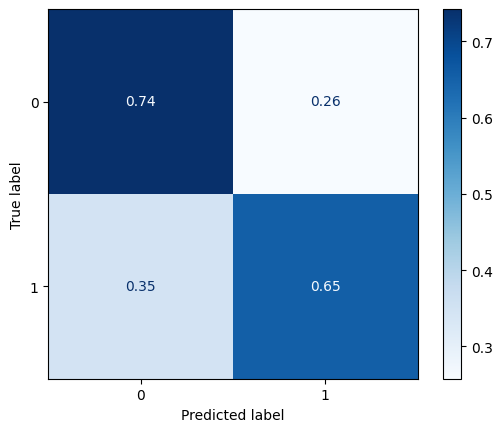

Test Evaluation
              precision    recall  f1-score   support

           0       0.58      0.49      0.53       269
           1       0.76      0.82      0.79       524

    accuracy                           0.71       793
   macro avg       0.67      0.65      0.66       793
weighted avg       0.70      0.71      0.70       793



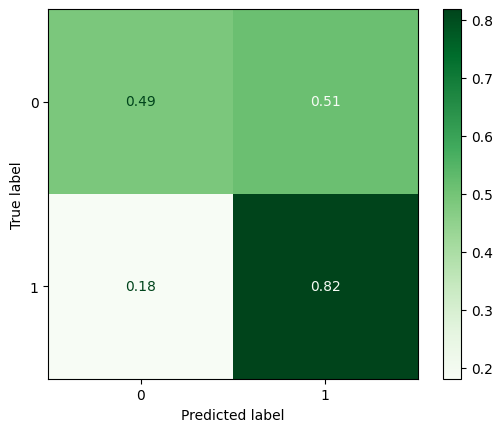

,train_acc,test_acc,train_prec,test_prec,train_recall,test_recall,train_f1,test_f1,train_auc,test_auc
log_reg_notune,0.728312,0.707440,0.740534,0.723242,0.694705,0.902672,0.716888,0.803056,0.796616,0.793886
dt_no_tune,1.000000,0.634300,1.000000,0.735887,1.000000,0.696565,1.000000,0.715686,1.000000,0.604788
rf_no_tune,1.000000,0.740227,1.000000,0.802281,1.000000,0.805344,1.000000,0.803810,1.000000,0.803506
RF 1 depth,0.698748,0.706179,0.713573,0.756614,0.654173,0.818702,0.682583,0.786434,0.757881,0.771794


In [54]:

rf_1 = eval_classification(rf_best_depth, X_train_proc, y_train, X_test_proc, y_test, model_name='RF 1 depth', results_frame=forest)
rf_1

In [55]:
%pip install xgboost

  Using cached xgboost-2.1.4-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-2.1.4-py3-none-win_amd64.whl (124.9 MB)
Note: you may need to restart the kernel to use updated packages.


In [56]:
import xgboost as xgb


In [57]:


boosted = xgb.XGBClassifier(  # Use XGBRegressor for regression tasks
    n_estimators=100,       # Number of trees
    learning_rate=0.1,      # Step size shrinkage
    max_depth=3,            # Maximum tree depth
    random_state=42         # For reproducibility
)

Train Evaluation
              precision    recall  f1-score   support

           0       0.72      0.82      0.77      4679
           1       0.79      0.67      0.73      4589

    accuracy                           0.75      9268
   macro avg       0.75      0.75      0.75      9268
weighted avg       0.75      0.75      0.75      9268



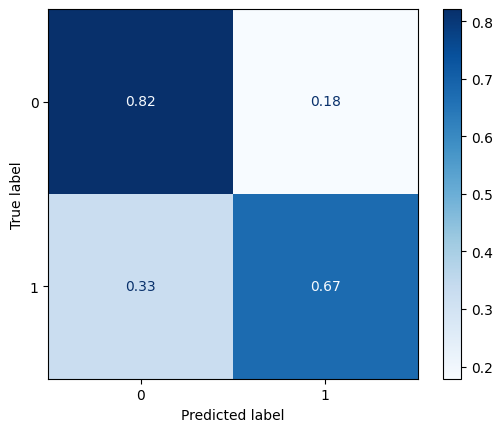

Test Evaluation
              precision    recall  f1-score   support

           0       0.63      0.58      0.60       269
           1       0.79      0.82      0.81       524

    accuracy                           0.74       793
   macro avg       0.71      0.70      0.71       793
weighted avg       0.74      0.74      0.74       793



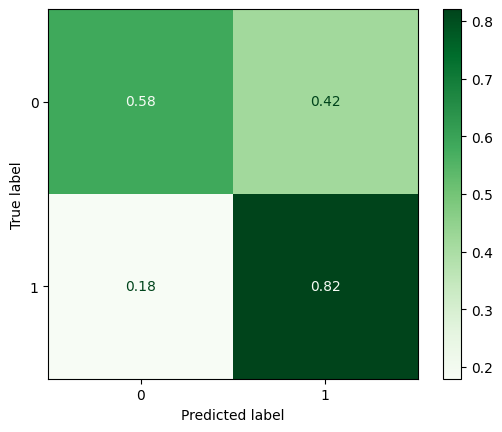

In [58]:
xgboost = eval_classification(boosted, X_train_proc, y_train, X_test_proc, y_test, model_name = 'xgboost', results_frame=rf_1)

In [59]:
xgboost

,train_acc,test_acc,train_prec,test_prec,train_recall,test_recall,train_f1,test_f1,train_auc,test_auc
log_reg_notune,0.728312,0.707440,0.740534,0.723242,0.694705,0.902672,0.716888,0.803056,0.796616,0.793886
dt_no_tune,1.000000,0.634300,1.000000,0.735887,1.000000,0.696565,1.000000,0.715686,1.000000,0.604788
rf_no_tune,1.000000,0.740227,1.000000,0.802281,1.000000,0.805344,1.000000,0.803810,1.000000,0.803506
RF 1 depth,0.698748,0.706179,0.713573,0.756614,0.654173,0.818702,0.682583,0.786434,0.757881,0.771794
xgboost,0.748489,0.740227,0.787131,0.793358,0.674439,0.820611,0.726441,0.806754,0.826923,0.803921


In [60]:
xg_gs = GridSearchCV(boosted,{"max_depth": [2, 4, 6], "n_estimators": [50, 100, 200]},
        verbose=1,
        n_jobs=-1,
    )


In [61]:
xg_gs.fit(X_train_proc, y_train)
print(xg_gs.best_score_)
print(xg_gs.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
0.31020823400171504
{'max_depth': 2, 'n_estimators': 50}


In [62]:
xg_tune = xg_gs.best_estimator_

Train Evaluation
              precision    recall  f1-score   support

           0       0.70      0.81      0.75      4679
           1       0.77      0.64      0.70      4589

    accuracy                           0.73      9268
   macro avg       0.73      0.73      0.73      9268
weighted avg       0.73      0.73      0.73      9268



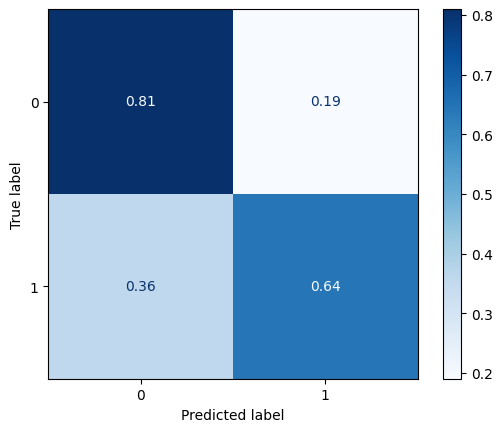

Test Evaluation
              precision    recall  f1-score   support

           0       0.62      0.60      0.61       269
           1       0.80      0.81      0.80       524

    accuracy                           0.74       793
   macro avg       0.71      0.71      0.71       793
weighted avg       0.74      0.74      0.74       793



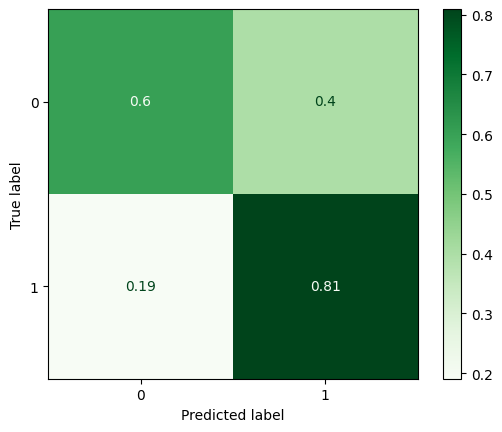

,train_acc,test_acc,train_prec,test_prec,train_recall,test_recall,train_f1,test_f1,train_auc,test_auc
log_reg_notune,0.728312,0.707440,0.740534,0.723242,0.694705,0.902672,0.716888,0.803056,0.796616,0.793886
dt_no_tune,1.000000,0.634300,1.000000,0.735887,1.000000,0.696565,1.000000,0.715686,1.000000,0.604788
rf_no_tune,1.000000,0.740227,1.000000,0.802281,1.000000,0.805344,1.000000,0.803810,1.000000,0.803506
RF 1 depth,0.698748,0.706179,0.713573,0.756614,0.654173,0.818702,0.682583,0.786434,0.757881,0.771794
xgboost,0.748489,0.740227,0.787131,0.793358,0.674439,0.820611,0.726441,0.806754,0.826923,0.803921
xg_tuned,0.727665,0.738966,0.768670,0.798493,0.643713,0.809160,0.700664,0.803791,0.798498,0.793127


In [63]:
boosted_tuned = eval_classification(xg_tune, X_train_proc, y_train, X_test_proc, y_test, model_name='xg_tuned', results_frame=xgboost)
boosted_tuned

In [72]:
# Encode y set

y_train_enc = ohe.fit_transform(y_train.values.reshape(-1,1)).to_numpy()
y_train_enc

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [73]:
y_test_enc = ohe.fit_transform(y_test.values.reshape(-1,1)).to_numpy()
y_test_enc

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]])

In [75]:
# Align encoded values with train and val set

y_test_enc = y_test_enc[y_test.index]
y_train_enc = y_train_enc[y_train.index]

IndexError: index 13270 is out of bounds for axis 0 with size 793

In [81]:
# make model function

def make_class_model():
  model = Sequential()
  model.add(Input(shape=(X_train_proc.shape[1],)))
  model.add(Dense(16, activation='relu', ))
  model.add(Dense(16, activation='relu'))
  model.add(Dense(y_test.nunique(), activation='softmax'))

  model.compile(optimizer='adam', loss='categorical_crossentropy',
                               metrics=['accuracy', AUC(name='auc')])

  return model


# Create model with function

neural_notune = make_class_model()

25/25 [==============================] - 0s 4ms/step
Train Evaluation
              precision    recall  f1-score   support

           0       0.68      0.84      0.75      4679
           1       0.78      0.60      0.68      4589

    accuracy                           0.72      9268
   macro avg       0.73      0.72      0.72      9268
weighted avg       0.73      0.72      0.72      9268



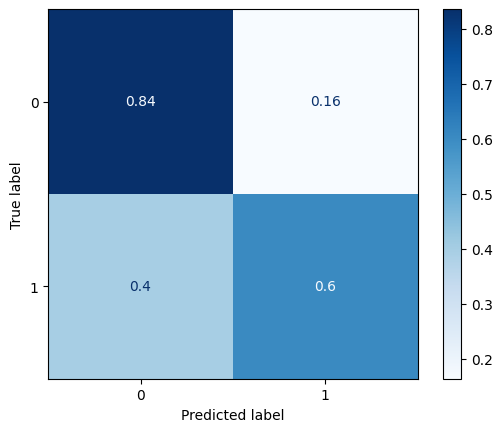

Test Evaluation
              precision    recall  f1-score   support

           0       0.59      0.56      0.57       269
           1       0.78      0.80      0.79       524

    accuracy                           0.72       793
   macro avg       0.68      0.68      0.68       793
weighted avg       0.71      0.72      0.72       793



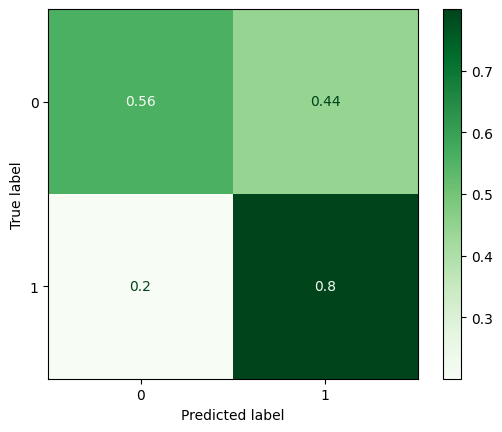

In [82]:
neur_first  = eval_classification(neural_notune, X_train_proc, y_train_enc, X_test_proc, y_test_enc, model_name='Neural No Tune', results_frame=boosted_tuned)

In [83]:
neur_first

,train_acc,test_acc,train_prec,test_prec,train_recall,test_recall,train_f1,test_f1,train_auc,test_auc
log_reg_notune,0.728312,0.707440,0.740534,0.723242,0.694705,0.902672,0.716888,0.803056,0.796616,0.793886
dt_no_tune,1.000000,0.634300,1.000000,0.735887,1.000000,0.696565,1.000000,0.715686,1.000000,0.604788
rf_no_tune,1.000000,0.740227,1.000000,0.802281,1.000000,0.805344,1.000000,0.803810,1.000000,0.803506
RF 1 depth,0.698748,0.706179,0.713573,0.756614,0.654173,0.818702,0.682583,0.786434,0.757881,0.771794
xgboost,0.748489,0.740227,0.787131,0.793358,0.674439,0.820611,0.726441,0.806754,0.826923,0.803921
xg_tuned,0.727665,0.738966,0.768670,0.798493,0.643713,0.809160,0.700664,0.803791,0.798498,0.793127
Neural No Tune,0.720868,0.717528,0.782768,0.778810,0.603835,0.799618,0.681757,0.789077,0.782328,0.778626


In [85]:
%pip install keras_tuner

  Using cached keras_tuner-1.4.7-py3-none-any.whl.metadata (5.4 kB)
  Using cached kt_legacy-1.0.5-py3-none-any.whl.metadata (221 bytes)
Using cached keras_tuner-1.4.7-py3-none-any.whl (129 kB)
Using cached kt_legacy-1.0.5-py3-none-any.whl (9.6 kB)
Note: you may need to restart the kernel to use updated packages.


In [86]:
import keras_tuner as kt


In [87]:

def tune_model(hp):
  num_layers = hp.Int('num_layers', min_value=1, max_value=3, step=1)
  num_units = hp.Int('layer_1_units', min_value=16, max_value=64, step=8)
  activation = hp.Choice('layer_1_activation', values=['relu', 'tanh', 'sigmoid'])
  dropout_rate = hp.Float('layer_1_dropout', min_value=0.0, max_value=.3, step=.1)

  model = Sequential()
  model.add(Input(shape=(X_train_proc.shape[1],), name='tune_input'))

  for i, _  in enumerate(range(num_layers)):
    model.add(Dense(units=num_units,
                    activation = activation,
                    name = f'tune_hidden_layer{i}'))
    model.add(Dropout(dropout_rate, name=f'tune_dropout_layer_{i}'))

  model.add(Dense(y_test.nunique(), activation='softmax', name='tune_output'))

  model.compile(optimizer='adam', loss='categorical_crossentropy',
                               metrics=['accuracy', AUC(name='auc')])

  return model

In [88]:
# Run tuner with parameters above

tuner = kt.Hyperband(tune_model,
                     objective='val_loss')

tuner.search(X_train_proc, y_train_enc, epochs=50, validation_split=.2, batch_size=256)

Trial 254 Complete [00h 00m 44s]
val_loss: 0.5574579238891602

Best val_loss So Far: 0.5466572642326355
Total elapsed time: 00h 23m 48s


In [89]:
# check for best params

best_params = tuner.get_best_hyperparameters()
best_params[0].values

{'num_layers': 3,
 'layer_1_units': 48,
 'layer_1_activation': 'relu',
 'layer_1_dropout': 0.1,
 'tuner/epochs': 12,
 'tuner/initial_epoch': 4,
 'tuner/bracket': 4,
 'tuner/round': 2,
 'tuner/trial_id': '0117'}

In [90]:
# Create model with best params

full_tune = tuner.get_best_models(num_models=1)[0]
full_tune.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tune_hidden_layer0 (Dense)  (None, 48)                5472      
                                                                 
 tune_dropout_layer_0 (Dropo  (None, 48)               0         
 ut)                                                             
                                                                 
 tune_hidden_layer1 (Dense)  (None, 48)                2352      
                                                                 
 tune_dropout_layer_1 (Dropo  (None, 48)               0         
 ut)                                                             
                                                                 
 tune_hidden_layer2 (Dense)  (None, 48)                2352      
                                                                 
 tune_dropout_layer_2 (Dropo  (None, 48)               0

25/25 [==============================] - 0s 3ms/step
Train Evaluation
              precision    recall  f1-score   support

           0       0.71      0.85      0.77      4679
           1       0.80      0.64      0.72      4589

    accuracy                           0.75      9268
   macro avg       0.76      0.75      0.74      9268
weighted avg       0.76      0.75      0.74      9268



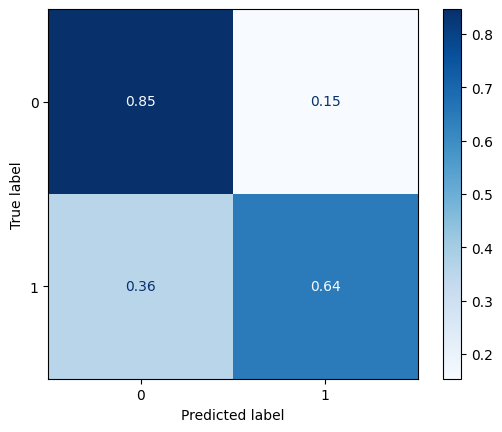

Test Evaluation
              precision    recall  f1-score   support

           0       0.59      0.51      0.55       269
           1       0.76      0.82      0.79       524

    accuracy                           0.71       793
   macro avg       0.68      0.66      0.67       793
weighted avg       0.70      0.71      0.71       793



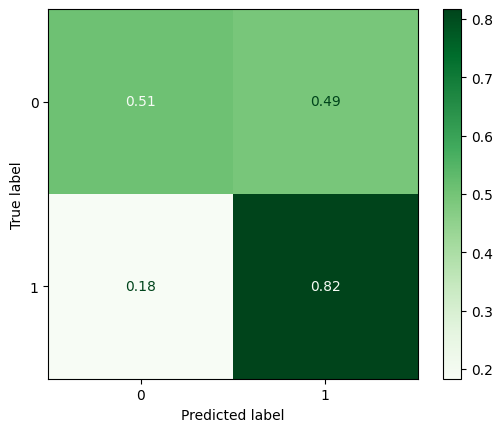

In [91]:
tuned_neur = eval_classification(full_tune, X_train_proc, y_train_enc, X_test_proc, y_test_enc, model_name = 'neural_tuned', results_frame = neur_first)

In [92]:
tuned_neur

,train_acc,test_acc,train_prec,test_prec,train_recall,test_recall,train_f1,test_f1,train_auc,test_auc
log_reg_notune,0.728312,0.707440,0.740534,0.723242,0.694705,0.902672,0.716888,0.803056,0.796616,0.793886
dt_no_tune,1.000000,0.634300,1.000000,0.735887,1.000000,0.696565,1.000000,0.715686,1.000000,0.604788
rf_no_tune,1.000000,0.740227,1.000000,0.802281,1.000000,0.805344,1.000000,0.803810,1.000000,0.803506
RF 1 depth,0.698748,0.706179,0.713573,0.756614,0.654173,0.818702,0.682583,0.786434,0.757881,0.771794
xgboost,0.748489,0.740227,0.787131,0.793358,0.674439,0.820611,0.726441,0.806754,0.826923,0.803921
xg_tuned,0.727665,0.738966,0.768670,0.798493,0.643713,0.809160,0.700664,0.803791,0.798498,0.793127
Neural No Tune,0.720868,0.717528,0.782768,0.778810,0.603835,0.799618,0.681757,0.789077,0.782328,0.778626
neural_tuned,0.746547,0.712484,0.804679,0.764286,0.644585,0.816794,0.715789,0.789668,0.810636,0.789175


In [93]:
full_tune.save('tuned_model')

INFO:tensorflow:Assets written to: tuned_model\assets
